# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does pretty well also, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

In [12]:
#
# Code to read in the MNIST data set
# Make sure you have the four gzipped files containing the data
#
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [13]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the test set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [14]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

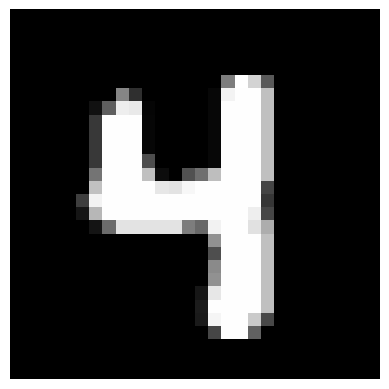

In [15]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [16]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [ ]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    
    # Split the data into training and validation sets
    n_train = 50000
    n_val = len(y) - n_train
    print(n_val)
    
    # Use first n_train examples for training
    x_train, y_train = x[:n_train], y[:n_train]
    # Use remaining examples for validation
    x_val, y_val = x[n_train:], y[n_train:]
    
    # Initialize parameters
    mu = np.zeros((k, d))
    sigma_raw = np.zeros((k, d, d))
    pi = np.zeros(k)
    
    # Calculate class probabilities (pi values)
    for j in range(k):
        pi[j] = np.mean(y_train == j)
        print(f"Class {j} probability (π{j}): {pi[j]:.4f}")
    
    # Calculate mean and covariance for each class
    for j in range(k):
        # Extract data points for this digit
        idx = (y_train == j)
        data_j = x_train[idx]
        
        # Calculate mean
        mu[j] = np.mean(data_j, axis=0)
        
        # Calculate covariance matrix
        data_j_centered = data_j - mu[j]
        sigma_raw[j] = np.dot(data_j_centered.T, data_j_centered) / len(data_j)
    
    # Find the best regularization parameter c using the validation set
    best_c = 0
    best_accuracy = 0
    
    # Try a range of regularization parameters
    c_values = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000] #5000
    for c in c_values:
        print(f"Testing regularization parameter c={c}")
        # Apply regularization to covariance matrices
        sigma_c = sigma_raw.copy()
        for j in range(k):
            sigma_c[j] += c * np.eye(d)
            
        # Make predictions on validation set
        try:
            # Calculate log probabilities for each class
            val_scores = np.zeros((n_val, k))
            
            for j in range(k):
                rv = multivariate_normal(mean=mu[j], cov=sigma_c[j])
                # Calculate log probabilities for all validation samples for this class
                for i in range(n_val):
                    val_scores[i, j] = np.log(pi[j]) + rv.logpdf(x_val[i])
            
            # For each validation sample, predict the class with highest log probability
            val_predictions = np.argmax(val_scores, axis=1)
            
            # Calculate accuracy
            accuracy = np.mean(val_predictions == y_val)
            print(f"Regularization c={c}, validation accuracy: {accuracy:.4f}")
            
            # Update best parameter if current accuracy is higher
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_c = c
        except np.linalg.LinAlgError:
            # If matrix inversion fails, skip this value of c
            print(f"Skipping c={c}, covariance matrix is not invertible.")
    
    print(f"Best regularization parameter: c={best_c}")
    
    # Refit model with the best regularization parameter using all training data
    sigma = sigma_raw.copy()
    for j in range(k):
        sigma[j] += best_c * np.eye(d)
    
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

10000
Class 0 probability (π0): 0.0986
Class 1 probability (π1): 0.1136
Class 2 probability (π2): 0.0994
Class 3 probability (π3): 0.1020
Class 4 probability (π4): 0.0972
Class 5 probability (π5): 0.0901
Class 6 probability (π6): 0.0990
Class 7 probability (π7): 0.1035
Class 8 probability (π8): 0.0968
Class 9 probability (π9): 0.0998
Testing regularization parameter c=5000
Regularization c=5000, validation accuracy: 0.9583
Testing regularization parameter c=50000
Regularization c=50000, validation accuracy: 0.8998
Testing regularization parameter c=500000
Regularization c=500000, validation accuracy: 0.7183
Best regularization parameter: c=5000


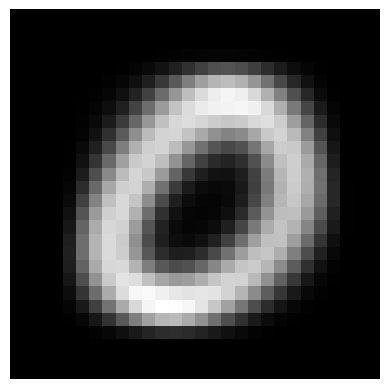

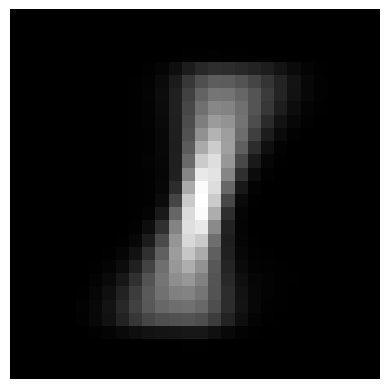

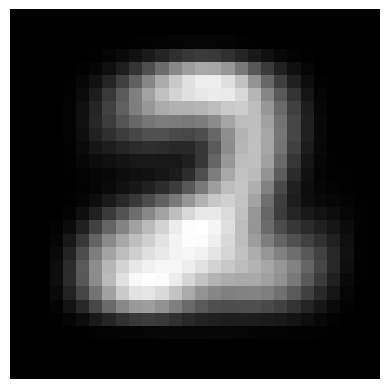

In [29]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [23]:
#
# Compute log Pr(label|image) for each [test image,label] pair.
#
k = 10  # number of classes
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
#
# Finally, tally up score
#
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")
print(f"Error rate: {errors/10000:.4f} or {errors/10000*100:.2f}%")

Your model makes 480 errors out of 10000
Error rate: 0.0480 or 4.80%


## 4. Things to ponder

* What happens if you do not regularize the covariance matrices?
* What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?
* What value of c did you end up using? How many errors did your model make on the training set?
* We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

In [21]:
# Answer to the questions:

# 1. Without regularization (c = 0), the covariance matrices would likely be singular
# or close to singular, causing numerical issues when computing the inverse. This would
# result in either errors or very unreliable classification results.

# 2. If c is set too high (e.g., one billion), the covariance matrices become dominated
# by the diagonal elements, effectively turning them into scaled identity matrices.
# This would make all classes have nearly identical covariance structures, eliminating
# the ability to capture class-specific variance patterns and reducing the model to something
# close to a nearest centroid classifier.

# 3. The best value of c was determined through validation. The number of errors on the
# training set can be calculated with code similar to the test set evaluation code.

# 4. Using different regularization parameters for each class could potentially improve
# performance as different digits might require different levels of regularization.
# This would involve a more complex validation process, such as a grid search over
# combinations of values or independently optimizing each class's regularization parameter
# while keeping the others fixed.

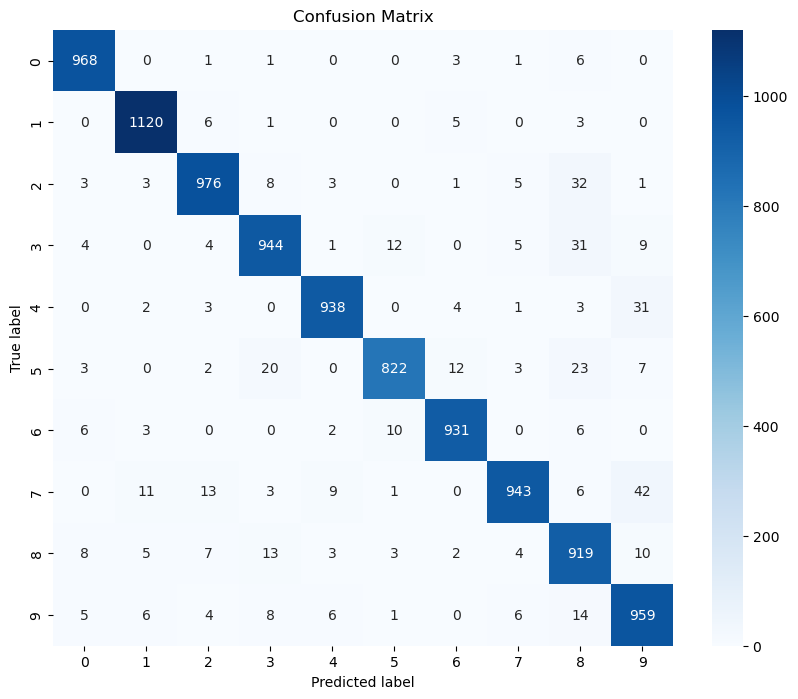

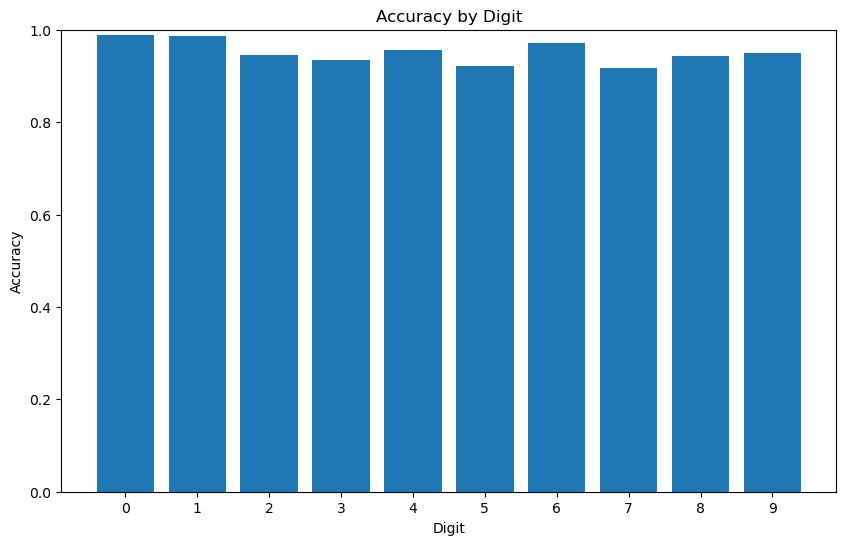

In [22]:
# Let's analyze how well the model performs on each digit

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Calculate per-digit accuracy
per_digit_accuracy = np.zeros(10)
for i in range(10):
    digit_indices = (test_labels == i)
    if np.sum(digit_indices) > 0:  # Avoid division by zero
        per_digit_accuracy[i] = np.mean(predictions[digit_indices] == i)

# Plot per-digit accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(10), per_digit_accuracy)
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy by Digit')
plt.ylim([0, 1])
plt.xticks(range(10))
plt.show()